## Analyse model connectivity


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import h5py
import pandas as pd
import scipy as scp

# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import transforms
#from brokenaxes import brokenaxes

import torch
import torch.nn as nn
#import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from statsmodels.stats.stattools import durbin_watson

import os
import sys
sys.path.append("..")

# BCN

from models import FullBCModel
from utils import get_data

# connectivity utils

from utils_connectivity import *


from scipy.stats import ttest_ind


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


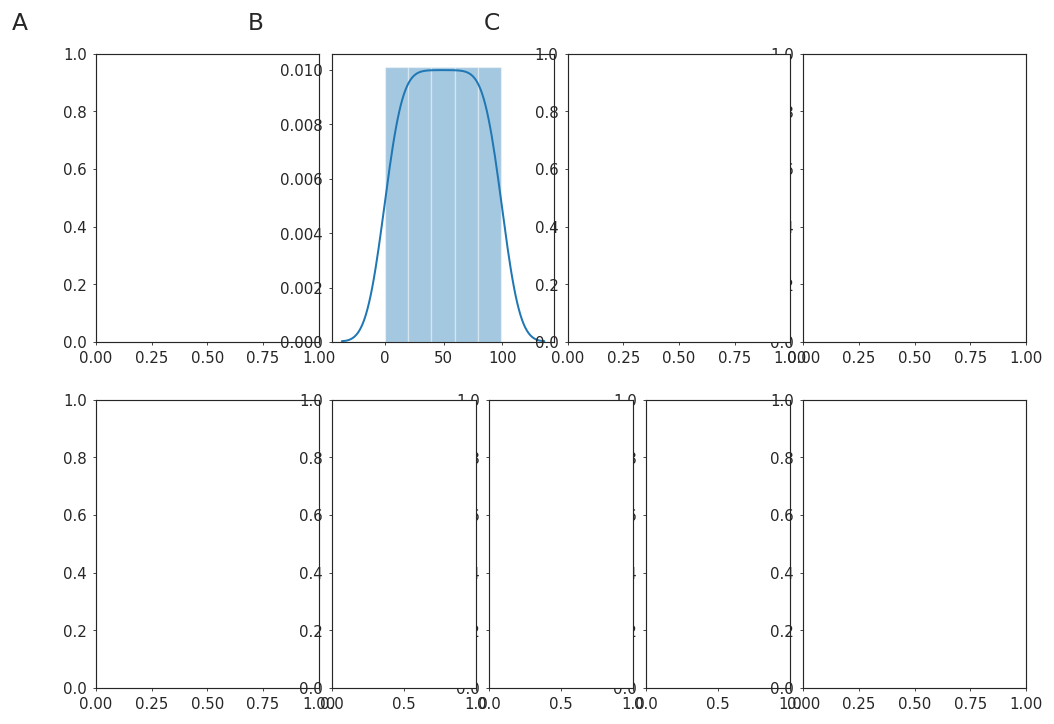

In [95]:
"""
utils 
"""
def clean_fig():
    sns.despine( top=True, right=True, left=True, bottom=True, offset=None, trim=False)
    plt.xticks([])
    plt.yticks([])
    


def panel_specs(layout, fig=None):
    # default arguments
    if fig is None:
        fig = plt.gcf()
    # format and sanity check grid
    lines = layout.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    linewidths = set(len(line) for line in lines)
    if len(linewidths)>1:
        raise ValueError('Invalid layout (all lines must have same width)')
    width = linewidths.pop()
    height = len(lines)
    panel_letters = set(c for line in lines for c in line)-set('.')
    # find bounding boxes for each panel
    panel_grid = {}
    for letter in panel_letters:
        left = min(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        right = 1+max(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        top = min(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        bottom = 1+max(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        panel_grid[letter] = (left, right, top, bottom)
        # check that this layout is consistent, i.e. all squares are filled
        valid = all(lines[y][x]==letter for x in range(left, right) for y in range(top, bottom))
        if not valid:
            raise ValueError('Invalid layout (not all square)')
    # build axis specs
    gs = gridspec.GridSpec(ncols=width, nrows=height, figure=fig)
    specs = {}
    for letter, (left, right, top, bottom) in panel_grid.items():
        specs[letter] = gs[top:bottom, left:right]
    return specs, gs

def panels(layout, fig=None):
    # default arguments
    if fig is None:
        fig = plt.gcf()
    specs, gs = panel_specs(layout, fig=fig)
    axes = {}
    for letter, spec in specs.items():
        axes[letter] = fig.add_subplot(spec)
    return axes, gs

def label_panel(ax, letter, *,
                offset_left=0.7, #0.8
                offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=14)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels_straight(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters.keys():
        ax = axes[letter]
        label_panel(ax, letters[letter], **kwds)
 

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

        
        
def set_rcParams():
    sns.set_context('paper')
    sns.set_style('ticks')
    plt.rcParams['axes.linewidth']    = .7
    plt.rcParams['xtick.major.width'] = .5
    plt.rcParams['ytick.major.width'] = .5
    plt.rcParams['xtick.minor.width'] = .5
    plt.rcParams['ytick.minor.width'] = .5
    plt.rcParams['xtick.major.size'] = 2
    plt.rcParams['ytick.major.size'] = 2
    plt.rcParams['xtick.minor.size'] = 1
    plt.rcParams['ytick.minor.size'] = 1
    plt.rcParams['font.size']       = 10#8
    plt.rcParams['axes.titlesize']  = 10 
    plt.rcParams['axes.labelsize']  = 10#8
    plt.rcParams['legend.fontsize'] = 9#7
    plt.rcParams['xtick.labelsize'] = 9#7
    plt.rcParams['ytick.labelsize'] = 9#7
    plt.rcParams['text.usetex'] = False
    plt.rcParams["savefig.dpi"] = 1200
    plt.rcParams['font.family'] = "Arial"
    plt.rcParams['figure.dpi'] = 120     # only affects the notebook
    
    
    
layout = '''
AAABBBCCCDDD
EEEFFGGHHIII
 '''
fig = plt.figure(figsize=(10, 7))
axes, spec = panels(layout, fig=fig)
sns.distplot(np.arange(0,100), ax=axes['B'])
spec.set_width_ratios([1,1,1,1,1,1,1,1,1,1,1,1])
label_panels(axes, letters=['A','C','B'])
plt.tight_layout()



# Load data

### model data

In [3]:
"""
Load data
returns: (X_local, X_global, chirp, types, sampling_frequency, exp_time,
            local_m, local_sd, global_m, global_sd)
"""
X_local, X_global, chirp, types, sampling_frequency, *_  = get_data(normalize=True,
                                                                    data_dir='../data')



In [4]:
"""
load weights 20 best models
NEW
"""
h5f = h5py.File('weights_20_best_v2.h5','r')
w_n = h5f['weights_20_best'][:]
loss_n = h5f['loss_20_best'][:]
load_best_lnr=  h5f['load_best_lnr'][:]
ids= h5f['ids'][:]
best_id= h5f['best_id'][()]
#h5f.close()

# get w of best model
w_best = np.squeeze(w_n[ids==best_id])
print('best_index:',np.argmax([ids==best_id]))

best_index: 6


In [84]:
ids

array([5435488, 9467066, 6882619, 2814149, 6776013, 4148169, 3359087,
       1764971, 6206087, 9200637, 3023378, 6620173, 5638737, 7243278,
       6705218, 7142284, 4755525, 1505282, 6218190, 5365148])

In [83]:
best_id

3359087

### Helmst data

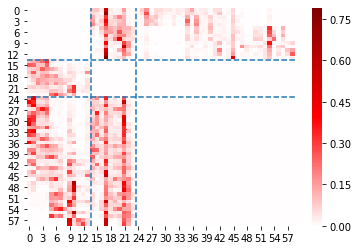

In [5]:
"""
## get Helmst comparison data 
sorted and preprocessed
"""

type2type = np.loadtxt('Type2TypeMx.txt')


#Calculating mean of matrix exluding SACs and RBCs rows. 
interm = np.copy(type2type)
interm[70,:] = 0
interm[:,70] = 0
interm[50,:] = 0
interm[:,50] = 0
interm[32,:] = 0
interm[:,32] = 0
meanWeight = np.mean(interm[np.where(type2type != 0)])
# ON SAC; OFF SAC, RBC: 71, 51, 33 still do - 1
meanRBC = np.mean(type2type[70,:])
meanSAC1 = np.mean(type2type[50,:])
meanSAC2 = np.mean(type2type[32,:])
x = meanWeight/meanRBC
type2type[70,:] = type2type[70,:]*x
type2type[:,70] = type2type[:,70]*x
x = meanWeight/meanSAC1
type2type[50,:] = type2type[50,:]*x
type2type[:,50] = type2type[:,50]*x
x = meanWeight/meanSAC2
type2type[32,:] = type2type[32,:]*x
type2type[:,32] = type2type[:,32]*x


new_diagonal = np.diag(type2type)*2

np.fill_diagonal(type2type, new_diagonal)

# 12 types of GCs that need to be removed

typetypeSmall = type2type[12:,12:]

# Set BC <-> BC to zero

typetypeSmall[-14:,-14:] = 0 

size = typetypeSmall.shape[0] - 14

# Indices of local ACs - 1 for python indexing - 12 for GCs
localAC = np.array([14,24,42,15,46,21,20,17,22,38]) - 1 - 12


t = np.linspace(0, size-1, size)
globalAC = np.array([int(i) for i in np.setdiff1d(t, localAC)])

BC = np.linspace(typetypeSmall.shape[0] - 14, typetypeSmall.shape[0]-1, 14)

for i in localAC:
    
    typetypeSmall[i,localAC] = 0
    typetypeSmall[i, globalAC] = 0
    
    
for j in globalAC: 
    
    typetypeSmall[j, globalAC] = 0
    
orderTotal = np.array([int(i) for i in np.concatenate((BC, localAC, globalAC))])
orderedArray = typetypeSmall[orderTotal][:,orderTotal]

#w_helm = np.copy(orderedArray)

"""
preprocessing
"""
# adding small positiv value to all entries
c=1e-10

w_bc_acl_helm = orderedArray[14:24,0:14] +c
w_bc_acg_helm = orderedArray[24:,0:14] +c


w_acl_bc_helm = orderedArray[0:14,14:24] +c
w_acg_bc_helm = orderedArray[0:14,-35:] +c #14,35

w_acl_acg_helm = orderedArray[-35:, 14:24] +c # 35, 10


w_helm = joining_ws(w_acl_bc_helm, w_bc_acl_helm, w_acg_bc_helm, w_bc_acg_helm, w_acl_acg_helm)

w_helm_norm = norm_full_w(w_helm)
    
w_helm_norm_sort = sorting(w_helm_norm)

sns.heatmap((w_helm_norm_sort),
           cmap='seismic',
           center=0)
plt.axhline(14,
           ls='--')
plt.axvline(14,
           ls='--')

plt.axhline(24,
           ls='--')
plt.axvline(24,
           ls='--')

In [6]:
"""
define plotting functions
"""

"""
get labels for BCs and ACs
"""
bc_labels=['BC1',
         'BC2',
         'BC3a',
         'BC3b',
         'BC4',
         'BC5t',
         'BC5o',
         'BC5i',
         'BCX',
         'BC6',
         'BC7',
         'BC8',
         'BC9',
         'BCR']

ac_l_labels = ['ac_l_'+str(i) for i in range(10)]
ac_g_labels = ['ac_g_'+str(i) for i in range(35)]

def plot_weights(w,
                 title=None,
                 figsize=(12, 4),
                 cmap='seismic',
                 center=0,
                 xlabels=None,
                 ylablels=None,
                 xticklabels=None,
                 yticklabels=None,
                 plot_hline=None,
                 plot_vline=None
                 ):
    """
    plots a weight matrix
    :param w:
    :param title:
    :param figsize:
    :param cmap:
    :param center: center of heatmap color
    :param xlabels:
    :param ylablels:
    :param xticklabels:
    :param yticklabels:
    :param plot_hline: plot horizontal line to divide ON and OFF BC
    :return:
    
    labels=['BC1',
                         'BC2',
                         'BC3a',
                         'BC3b',
                         'BC4',
                         'BC5t',
                         'BC5o',
                         'BC5i',
                         'BCX',
                         'BC6',
                         'BC7',
                         'BC8',
                         'BC9',
                         'BCR']
    
    """

    #plt.figure(figsize=figsize)
    #plt.title(title)
    sns.heatmap(w,
                cmap=cmap,
                center=center,
                yticklabels=yticklabels,
                xticklabels=xticklabels
                )
    plt.xlabel(xlabels)
    plt.yticks(rotation=0)
    if plot_hline !=None:
        plt.axhline(plot_hline, ls='--', c='black')
    if plot_vline != None:
        plt.axvline(plot_vline, ls=':', c='black')

# Start with analysis

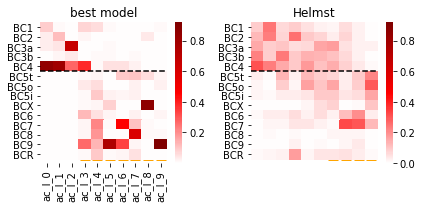

In [25]:
"""
nice plots for BC -> local
"""

save = False

# for best model
w_norm = norm_full_w(w_best)
w_norm_sort, ac_l_type, ac_g_type = sorting(w_norm, return_types=True)
ac_l_type[ac_l_type==0]=np.nan
ac_g_type[ac_g_type==0]=np.nan
w_acl_bc_best, w_bc_acl_best, w_acg_bc_best, w_bc_acg_best, w_acl_acg_best = un_joining_w(w_norm_sort)

### For helmst
w_helm_norm = norm_full_w(w_helm)
w_helm_norm_sort, ac_l_type_helm, ac_g_type_helm = sorting(w_helm_norm, return_types=True)
ac_l_type_helm[ac_l_type_helm==0]=np.nan
ac_g_type_helm[ac_g_type_helm==0]=np.nan
w_acl_bc_helm, w_bc_acl_helm, w_acg_bc_helm, w_bc_acg_helm, w_acl_acg_helm = un_joining_w(w_helm_norm_sort)


bc_labels=['BC1',
         'BC2',
         'BC3a',
         'BC3b',
         'BC4',
         'BC5t',
         'BC5o',
         'BC5i',
         'BCX',
         'BC6',
         'BC7',
         'BC8',
         'BC9',
         'BCR']

ac_l_labels = ['ac_l_'+str(i) for i in range(10)]
ac_g_labels = ['ac_g_'+str(i) for i in range(35)]


cmap='seismic'
center=0
xlabels=None
ylablels=None

plot_hline=5
plot_vline=None, #on_off_split
xticklabels = np.array(ac_l_labels)
yticklabels=bc_labels

vmax = np.max(np.hstack([w_bc_acl_best, w_bc_acl_helm]))


plt.figure(1, figsize=(6,3))

plt.subplot(1,2,1)
plt.title('best model')
sns.heatmap(w_bc_acl_best.T,
                cmap=cmap,
                center=center,
                yticklabels=yticklabels,
                xticklabels=xticklabels,
                square=False,
                vmax=vmax,
                cbar=True
                )
plt.xlabel(xlabels)
ax=plt.gca()
#ax.set_xticklabels([])
#ax.set_xticks([])
plt.yticks(rotation=0)
if plot_hline !=None:
    plt.axhline(plot_hline, ls='--', c='black')

# plot small stripes for AC type
plt.plot(np.arange(len(ac_l_type))+0.5,
         ac_l_type*14.1,
         '_',
         markersize=10,
        color='orange')
plt.ylim(14.4,0)
plt.ylim(14.4,0)


plt.subplot(1,2,2)
plt.title('Helmst')
sns.heatmap(w_bc_acl_helm.T,
                cmap=cmap,
                center=center,
                yticklabels=yticklabels,
                xticklabels=xticklabels,
                square=False,
            vmax=vmax
                )
plt.xlabel(xlabels)
ax=plt.gca()
ax.set_xticklabels([])
ax.set_xticks([])
plt.yticks(rotation=0)
if plot_hline !=None:
    plt.axhline(plot_hline, ls='--', c='black')

# plot small stripes for AC type
plt.plot(np.arange(len(ac_l_type_helm))+0.5,
         ac_l_type_helm*14.1,
         '_',
         markersize=10,
        color='orange')
plt.ylim(14.4,0)
plt.ylim(14.4,0)




plt.tight_layout()



if save:
    filepath = 'None'
    filename = 'w_bc_acl'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

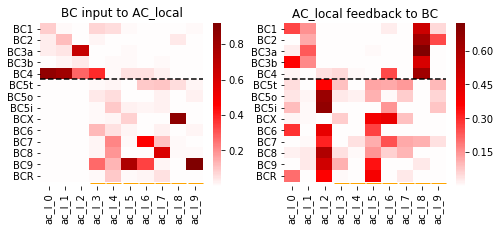

(10.2, 0)

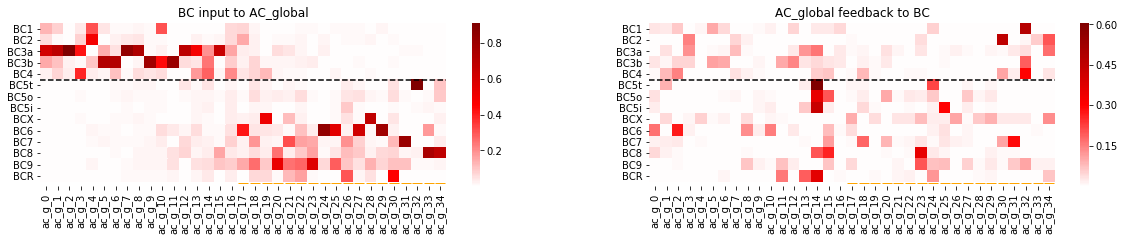

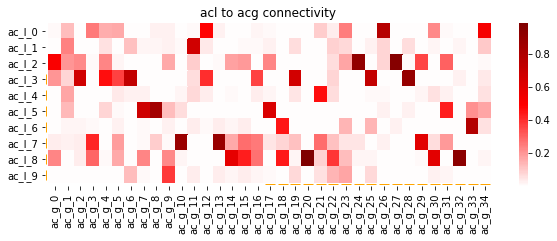

In [7]:
w_norm = norm_full_w(w_best)

w_norm_sort, ac_l_type, ac_g_type = sorting(w_norm, return_types=True)
ac_l_type[ac_l_type==0]=np.nan
ac_g_type[ac_g_type==0]=np.nan

w_acl_bc, w_bc_acl, w_acg_bc, w_bc_acg, w_acl_acg = un_joining_w(w_norm_sort)




"""
plot weights local
"""

plt.figure(1, figsize = (8,3))
plt.subplot(1,2,1)
plt.title('BC input to AC_local')
plot_weights(w_bc_acl.T,
             plot_hline=5,
             plot_vline=None, #on_off_split,
             xticklabels = np.array(ac_l_labels),
            yticklabels=bc_labels,
            center=0)

# plot small stripes for AC type
plt.plot(np.arange(len(ac_l_type))+0.5,
         ac_l_type*14.1,
         '_',
         markersize=15,
        color='orange')
plt.ylim(14.4,0)


plt.subplot(1,2,2)
plt.title('AC_local feedback to BC')
plot_weights(w_acl_bc, 
             plot_hline=5,
             plot_vline=None, #on_off_split,
             yticklabels=bc_labels,
            xticklabels=np.array(ac_l_labels)
            )

# plot small stripes for AC type
plt.plot(np.arange(len(ac_l_type))+0.5,
         ac_l_type*14.1,
         '_',
         markersize=15,
        color='orange')
plt.ylim(14.4,0)

plt.show()


"""
plot weights global
"""
plt.figure(2, figsize = (20,3))
plt.subplot(1,2,1)
plt.title('BC input to AC_global')
plot_weights(w_bc_acg.T,
             plot_hline=5,
             plot_vline=None,
             xticklabels = np.array(ac_g_labels),
            yticklabels=bc_labels,
            center=0)
# plot small stripes for AC type
plt.plot(np.arange(len(ac_g_type))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=10,
        color='orange')
plt.ylim(14.4,0)

plt.subplot(1,2,2)
plt.title('AC_global feedback to BC')
plot_weights(w_acg_bc, 
             plot_hline=5,
             plot_vline=None,
             yticklabels=bc_labels,
            xticklabels=np.array(ac_g_labels)
            )
# plot small stripes for AC type
plt.plot(np.arange(len(ac_g_type))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=10,
        color='orange')
plt.ylim(14.4,0)


"""
acl acg connection
"""

plt.figure(3, figsize = (10,3))
plt.title('acl to acg connectivity')

plot_weights(w_acl_acg.T,
            yticklabels=np.array(ac_l_labels),
            xticklabels=np.array(ac_g_labels))

plt.plot(np.arange(len(ac_g_type))+0.5,
         ac_g_type*10.1,
         '_',
         markersize=10,
        color='orange')
plt.ylim(10.2,0)

plt.plot(ac_l_type*0.01-0.2,
        np.arange(len(ac_l_type))+0.5,
         '|',
         markersize=10,
        color='orange')
plt.xlim(-.3)
plt.ylim(10.2,0)

# Correlation analysis

In [241]:
"""
random baseline
"""

def get_random_w(mode='uniform', b=None, zero_inflating=False, zeros=None, threshold=1e-5,w_ref=None):
    """
    
    """
    if mode=='uniform':
        lower=0
        upper=1
        # acl_bc
        w_acl_bc = np.random.uniform(lower,upper,(14,10))
        # bc_acl
        w_bc_acl = np.random.uniform(lower,upper,(10,14))
        # acg_bc
        w_acg_bc= np.random.uniform(lower,upper,(14,35))
        # bc_acg
        w_bc_acg = np.random.uniform(lower,upper,(35,14))
        # acl_acg
        w_acl_acg = np.random.uniform(lower,upper,(35,10))
    elif mode=='normal':
        print('not yet implemented')
        
    elif mode=='laplace':
        m=0
        # acl_bc
        w_acl_bc = np.abs(np.random.laplace(m,b,(14,10)))
        # bc_acl
        w_bc_acl =np.abs(np.random.laplace(m,b,(10,14)))
        # acg_bc
        w_acg_bc= np.abs(np.random.laplace(m,b,(14,35)))
        # bc_acg
        w_bc_acg = np.abs(np.random.laplace(m,b,(35,14)))
        # acl_acg
        w_acl_acg = np.abs(np.random.laplace(m,b,(35,10)))   
        
    elif mode=='data_distribution':
        # acl_bc
        w_acl_bc = get_random_weight_samples_from_data(w_ref,(14,10))
        # bc_acl
        w_bc_acl = get_random_weight_samples_from_data(w_ref,(10,14))
        # acg_bc
        w_acg_bc= get_random_weight_samples_from_data(w_ref,(14,35))
        # bc_acg
        w_bc_acg = get_random_weight_samples_from_data(w_ref,(35,14))
        # acl_acg
        w_acl_acg = get_random_weight_samples_from_data(w_ref,(35,10))
        
        
    else:
        print('not yet implemented')
        
        
    w = joining_ws(w_acl_bc,
                   w_bc_acl,
                   w_acg_bc,
                   w_bc_acg,
                   w_acl_acg)
    
    if zero_inflating:
        while np.sum(w<=threshold)<zeros:
            # really not efficient method:
            #i = np.random.randint(0,59)
            #j = np.random.randint(0,59)
            #w[i,j] = threshold

            val = np.random.choice(w[w>threshold])
            index = np.argmax(np.isclose(w,val))
            w = w.flatten()
            w[index] = threshold
            w = w.reshape(59,59)
    
    return w
def get_random_norm_sort(w_ref,const,zero_inflating, mode='laplace',norm=True, return_scale=False):
    """
    
    """
    if const==0:
        const=1e-10
    
    #b = w_ref[w_ref>const].std() / 2**0.5
    # var=2*b**2 => b = std/sqrt(2)
    
    #ML-Estimation for laplace scale (with zero mean)
    b = np.mean(np.abs(w_ref[w_ref>const]))

    
    if zero_inflating:
        # number of small values
        zeros = np.sum(w_ref<const)
    else:
        zeros=0
        
    w_random = get_random_w(mode=mode,
                                 b=b,
                                 threshold=1e-5,
                                 zeros=zeros,
                                zero_inflating=zero_inflating,
                                w_ref=w_ref
                                )
    
    if norm:
        w_random_norm = norm_full_w(w_random)
        w_final = sorting(w_random_norm)
    else:
        w_final = sorting(w_random)
    
    if return_scale:
        return w_final, b

    else:
        return w_final
    

def get_baseline(w_ref_random, w_ref_corr, const, n=100, zero_inflating=False,norm=True, mode='laplace'):
    """
    get baseline correlation
    with samples which are similar to w_ref
    ---
    :w_ref_random: reference weights for random sampling. first normalized than sorted. 
    :w_ref_corr: reference weights to compute correlation
    :const: only include values larger than this
    
    returns: np.array(corr), np.array(var), np.array(m), np.array(w_all)
    """
    
    corr = []
    var = []
    m = []
    w_all = []
    for i in range(n):

        w_random_norm_sort = get_random_norm_sort(w_ref_random, const, zero_inflating,mode=mode,norm=norm)
        
        for j in range(w_ref_corr.shape[0]):
            corr.append(get_corr(w_ref_corr[j], w_random_norm_sort))
        
        var.append(np.var(w_random_norm_sort[w_random_norm_sort>const]))
        m.append(np.mean(w_random_norm_sort[w_random_norm_sort>const]))
        w_all.append(w_random_norm_sort)
        
    return np.array(corr), np.array(var), np.array(m), np.array(w_all)

def get_random_weight_samples_from_data(w_ref,shape,lower=0,upper=1,dt=0.001):
    """
    excluding values==0, since right=True in np.digitize
    """
    n = shape[0]*shape[1]
    bins=np.arange(lower,upper,dt)
    binned_data_indeces = np.digitize(w_ref, bins=bins, right=True)
    random_inds = np.random.choice(binned_data_indeces[binned_data_indeces>0].flatten(),size=n)
    random_samples = bins[random_inds]
    random_samples = random_samples.reshape(shape)
    return random_samples

final correlation 0.13605289444440813


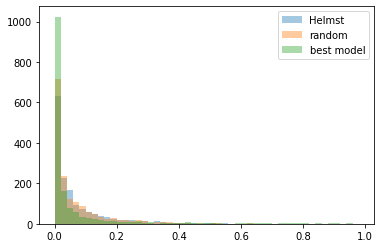

In [20]:
"""
weight distribution
SKIP
"""

w_norm = norm_full_w(w_best)
w_norm_sort_best= sorting(w_norm, return_types=False)



const = 1e-10
w_ref = w_helm_norm_sort

b = w_ref[w_ref>const].std()/2**0.5
# var=2*b**2 => b = std/sqrt(2)

#zeros = np.sum(w_ref<const)
zeros=0

w_random_norm = norm_full_w(get_random_w(mode='data_distribution',
                                         b=b,
                                         threshold=1e-10,
                                         zeros=zeros, 
                                         w_ref=w_helm_norm_sort
                                        ))

w_random_norm_sort = sorting(w_random_norm)

bins = np.arange(0,50)/50
kde=False
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(),bins=bins, label='Helmst',kde=kde)

sns.distplot( w_random_norm_sort[w_random_norm_sort>const].flatten(),bins=bins, label='random',kde=kde)
sns.distplot( w_norm_sort_best[w_norm_sort_best>const].flatten(),bins=bins, label='best model',kde=kde)
plt.legend()

corr = get_corr(w_ref, w_random_norm_sort)
print('final correlation',corr)

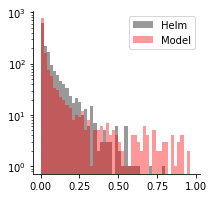

In [9]:
"""
weight distribution of all best X models
"""
save=False
filename = 'w_distribution_base100_h'

plot_random_baseline=False
plot_model=True




w_n_norm_sort = np.zeros(w_n.shape)
for i in range(w_n.shape[0]):
    w_norm = norm_full_w(w_n[i])
    w_n_norm_sort[i] = sorting(w_norm, return_types=False)

w_norm = norm_full_w(w_best)
w_best_norm_sort = sorting(w_norm, return_types=False)

const=1e-5

bins=np.arange(0,1,0.02)
plt.figure(1,figsize=(3,3))
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(),
             bins=bins,
            kde=False,
            label='Helm',
            norm_hist=False,
            color='black')
if plot_model:
    sns.distplot(
        #w_20_norm_sort[w_n_norm_sort>const].flatten(),
        w_best_norm_sort[w_best_norm_sort>const].flatten(),
                 bins=bins,
                 kde=False,
                label='Model',
                norm_hist=False,
                color='r')
if plot_random_baseline:
    sns.distplot(w_random_all[w_random_all>const].flatten(),
                 bins=bins,
                 kde=False,
                label='random',
                norm_hist=False,
                color='b')

plt.yscale('log')
#plt.ylim(0.5)
plt.legend()
sns.despine()


if save:
    filepath = 'None'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

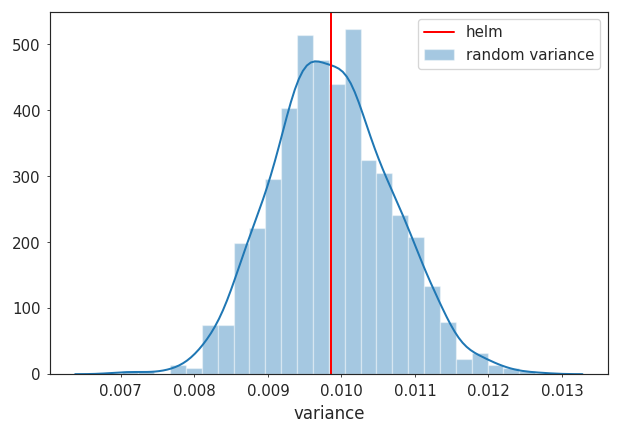

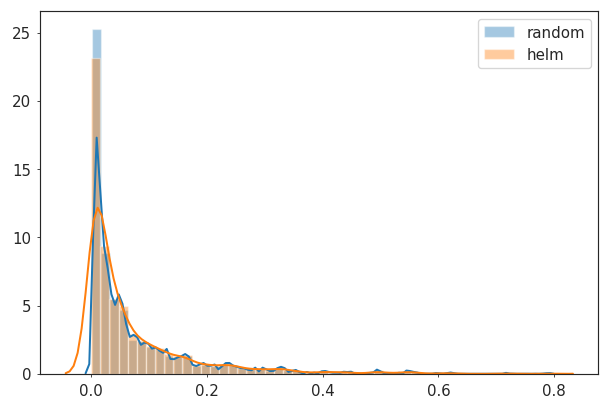

In [234]:
"""
get baseline correlations
"""
corr_baseline, var_baseline, mean_baseline, w_random_all = get_baseline(w_helm_norm_sort,
                                                                        w_ref_corr=w_n_norm_sort,
                                                                        const=0,
                                                                        n=1000,
                                                                        zero_inflating=False,
                                                                        norm=False,
                                                                       mode='data_distribution')

"""
check baseline distributions
"""

#bins = np.arange(0,100)/100
sns.distplot(var_baseline, label='random variance', 
            # bins=bins
            )
plt.axvline(np.var(w_helm_norm_sort[w_helm_norm_sort>0]), c='r', label='helm')
plt.xlabel('variance')
plt.legend()

plt.show()

const=1e-10
kde=True
sns.distplot( w_random_all[w_random_all>const].flatten(), label='random',kde=kde)
#sns.distplot( w_100_norm_sort[w_100_norm_sort>const].flatten(), label='all 100 model',kde=kde)
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(), label='helm',kde=kde)


plt.legend()

In [235]:
"""
get best model correlation 
and n best
"""

corr_model_best = get_corr(sorting(norm_full_w(w_best)), sorting(norm_full_w(w_helm)))
p = 1- np.sum(corr_baseline<corr_model_best)/len(corr_baseline)
print('best model: p =',p.round(3) )
print('corr of best model:',corr_model_best)

w_ref_corr = sorting(norm_full_w(w_helm))
correlation_n = []
var_n = []
w_norm_sort_all=[]
for i in range(w_n.shape[0]):
    #w_norm = norm_full_w(w_100[i])
    #w_norm_sort = sorting(w_100[i])
    correlation_n.append(get_corr(sorting(norm_full_w(w_n[i])),w_ref_corr ))
    var_n.append(np.var(w_norm_sort))
    w_norm_sort_all.append(w_norm_sort)
    
    
correlation_n = np.array(correlation_n)
var_n = np.array(var_n)
w_norm_sort_all = np.array(w_norm_sort_all)

best model: p = 0.001
corr of best model: 0.12763381168935425


(0, 0.4)

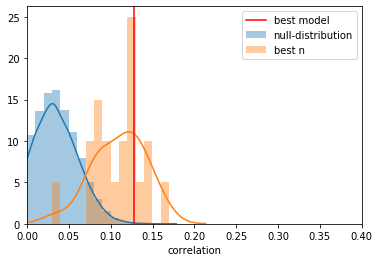

In [12]:

bins = np.arange(0,1,0.01)
sns.distplot(corr_baseline, label='null-distribution', bins=bins)
sns.distplot(correlation_n, label='best n', bins=bins)
plt.axvline(corr_model_best, c='r', label='best model')
plt.xlabel('correlation')
plt.legend()
plt.xlim(0,0.4)



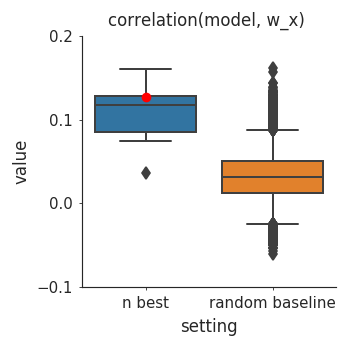

In [236]:
"""
plot correlations
"""
save=False
filename = 'correlations'

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= correlation_n
df['setting'] = ['n best']*len(var_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline
df2['setting'] = ['random baseline']*len(corr_baseline)

df = df.append(df2)

plt.figure(1, figsize=(3,3))
plt.title('correlation(model, w_x) ')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            whis=True
            
       )

plt.plot(0,
         corr_model_best,
         'o',
        color='red',
        label='best model')
#plt.legend()
plt.ylim(-0.1)
plt.yticks([-0.1,0,0.1,0.2])

sns.despine()
plt.tight_layout()

if save:
    filepath = None
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

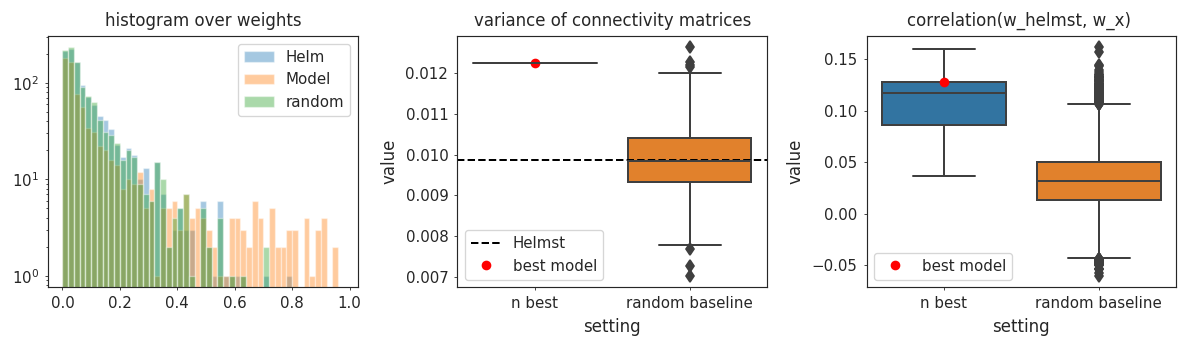

In [237]:
w_norm_sort_best = sorting(norm_full_w(w_best))



df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= var_n
df['setting'] = ['n best']*len(var_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=var_baseline
df2['setting'] = ['random baseline']*len(var_baseline)

df3 = pd.DataFrame(columns=['value', 'type', 'setting'])
df3['value']= np.var(w_helm_norm_sort)
df3['setting'] = ['Helmst']

df = df.append(df2)
#df = df.append(df3)

plt.figure(1, figsize=(10,3))
#############################################################
plt.subplot(1,3,1)
plt.title('histogram over weights')

kde=False

const=0.01
bins = np.arange(0,50)/50
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(),
             bins=bins,
            kde=kde,
            label='Helm')
sns.distplot(w_norm_sort_best[w_norm_sort_best>const].flatten(),
             bins=bins,
             kde=kde,
            label='Model')

sns.distplot(w_random_all[0][w_random_all[0]>const].flatten(),
             bins=bins,
             kde=kde,
            label='random')
plt.yscale('log')
#plt.ylim(0.5)
plt.legend()
#########################################################
plt.subplot(1,3,2)

plt.title('variance of connectivity matrices')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            #ci='sd'
       )
plt.axhline(np.var(w_helm_norm_sort[w_helm_norm_sort>0]), 
           color='black',
           ls='--',
           label='Helmst')

plt.plot(0,
         np.var(w_norm_sort_best),
         'o',
        color='red',
        label='best model')
plt.legend()
###########################

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= correlation_n
df['setting'] = ['n best']*len(correlation_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline
df2['setting'] = ['random baseline']*len(corr_baseline)

df = df.append(df2)


plt.subplot(1,3,3)
plt.title('correlation(w_helmst, w_x) ')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            
       )

plt.plot(0,
         corr_model_best,
         'o',
        color='red',
        label='best model')
plt.legend()
plt.tight_layout()



In [242]:
"""
calculate p values for full data

- choose only one of w_n_best as ref 
"""

norm=False
const = 0.0
zero_inflating=False
mode='data_distribution'

"""
for best model
"""

np.random.seed(1)
corr_best_p = get_corr(w_helm_norm_sort, w_best_norm_sort)


corr_baseline_p_best, _,_,_ = get_baseline(w_helm_norm_sort,
                                            w_ref_corr=np.array([w_norm_sort_best]),
                                            const=0,
                                            n=1000,
                                            zero_inflating=False,
                                            norm=False,
                                           mode='data_distribution')

p_best =  np.sum(corr_baseline_p_best>corr_best_p)/len(corr_baseline_p_best)

"""
for n best models

# use: correlation_n
"""
corr_baseline_p_n = []
p_n = []
for i in range(w_n_norm_sort.shape[0]):
    np.random.seed(1)
    corr_baseline_p_i, _,_,_ = get_baseline(w_helm_norm_sort,
                                            w_ref_corr=np.array([w_n_norm_sort[i]]),
                                            const=0,
                                            n=1000,
                                            zero_inflating=False,
                                            norm=False,
                                           mode='data_distribution')
    corr_baseline_p_n.append(corr_baseline_p_i)
    p_n.append(np.sum(corr_baseline_p_n[i]>correlation_n[i])/len(corr_baseline_p_n[i]))


print('p (best model): ', p_best)
print('p_range of n best (min,max):', np.min(p_n),np.max(p_n))
print('all p_n:',p_n)

p (best model):  0.002
p_range of n best (min,max): 0.0 0.44
all p_n: [0.033, 0.44, 0.007, 0.001, 0.002, 0.041, 0.002, 0.003, 0.0, 0.0, 0.001, 0.014, 0.003, 0.042, 0.004, 0.0, 0.081, 0.0, 0.039, 0.023]


In [222]:
correlation_n

array([0.0861373 , 0.03641407, 0.10833621, 0.1220778 , 0.12490469,
       0.08529025, 0.12763381, 0.11666773, 0.14813422, 0.14807948,
       0.16019284, 0.09617844, 0.12449345, 0.08206868, 0.11875919,
       0.139149  , 0.07435768, 0.12826054, 0.07901068, 0.0904476 ])

## collapsing to on off

In [15]:

def get_baseline_collapsed(w_ref_random, w_ref_corr, const,zero_inflating=True, n=100, norm=True,mode='laplace'):
    """
    get baseline correlation
    with samples which are similar to w_ref
    ---
    : w_ref_random: reference weights for random sampling. first normalized than sorted
    : w_ref_corr: reference weights for correlation
    """    
    
    # collapse all w_ref_corr
    w_ref_corr_collapsed = []
    for j in range(w_ref_corr.shape[0]):
        w_ref_corr_collapsed.append(collapse_on_off(w_ref_corr[j]))
    w_ref_corr_collapsed=np.array(w_ref_corr_collapsed)
    
    corr = []
    for i in range(n):
        w_random_norm_sort = get_random_norm_sort(w_ref_random, const,zero_inflating ,mode=mode, norm=norm)
        w_collapsed = collapse_on_off(w_random_norm_sort)
        for j in range(w_ref_corr_collapsed.shape[0]):
            corr.append(get_corr_collapsed(w_ref_corr_collapsed[j], w_collapsed))
        
    return np.array(corr)
        

def get_corr_collapsed(w1,w2):
    """
    masking out 0-entries
    """
    mask = np.ones((6,6), dtype=int)
    mask[:2,:2] = 0
    mask[2:4,2:6] = 0
    mask[4:6,4:6] = 0
    #plt.imshow(mask)
    corr = np.corrcoef(w1[mask].flatten(),w2[mask].flatten())[0,1]
    return corr    

In [16]:
"""
get correlations for n best models
and best model
"""
#w_norm = norm_full_w(w_best)
#w_norm_sort = sorting(w_norm)


w_helm_collapsed = collapse_on_off(sorting(norm_full_w(w_helm)))
w_model_collapsed = collapse_on_off(sorting(norm_full_w(w_best)))
corr_model_collapsed = get_corr_collapsed(w_helm_collapsed, w_model_collapsed)


corr_collapsed_n = []

for i in range(w_n.shape[0]):
    #w_norm = norm_full_w(w_100[i])
    #w_norm_sort=sorting(w_norm)
    w_collapsed = collapse_on_off(sorting(norm_full_w(w_n[i])))
    corr_collapsed_n.append(get_corr_collapsed(w_helm_collapsed, w_collapsed))
    
corr_collapsed_n = np.array(corr_collapsed_n)

In [17]:
"""
get correlation baseline
and one random sample
"""

norm=False
const = 0.0
zero_inflating=False
mode='data_distribution'

np.random.seed(1)

corr_baseline_collapsed = get_baseline_collapsed(w_helm_norm_sort, 
                                                 w_ref_corr=w_n_norm_sort,
                                                 const=const, 
                                                 n=1000,
                                                 norm=norm,
                                                 zero_inflating=zero_inflating,
                                                mode=mode)

w_random_collapsed =  collapse_on_off( get_random_norm_sort(w_helm_norm_sort, 
                                                            const=const,
                                                            zero_inflating=zero_inflating,
                                                            mode=mode,
                                                           norm=norm))
corr_random_collapsed = get_corr_collapsed(w_helm_collapsed, w_random_collapsed)

In [18]:
print('mean baseline:',corr_baseline_collapsed.mean())
print('mean 100 best:', corr_collapsed_n.mean())
print('corr random sample: ', corr_random_collapsed)

mean baseline: 0.5077180125011455
mean 100 best: 0.6789478562892735
corr random sample:  0.6924114914782754


Text(0.5, 6.0, 't-test: p= 4.90797082039548e-12')

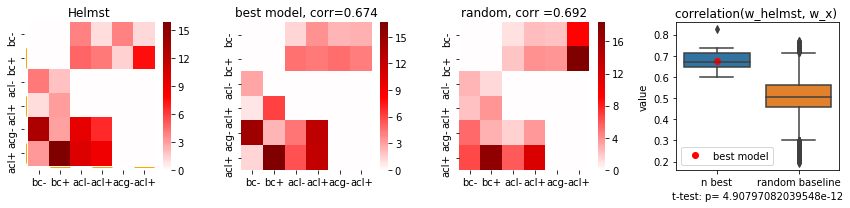

In [19]:
cmap='seismic'

labels=['bc-','bc+','acl-','acl+','acg-','acl+']

plt.figure(1, figsize=(12,3))

cbar=True
plt.subplot(1,4,1)
plt.title('Helmst')
sns.heatmap(w_helm_collapsed,cmap=cmap,center=0,cbar=cbar)

ax=plt.gca()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.subplot(1,4,2)
plt.title('best model, corr='+ str(corr_model_collapsed.round(3)))
sns.heatmap(w_model_collapsed,cmap=cmap,center=0,cbar=cbar)

# plot small stripes types
types = np.ones(6)
types[0]=np.nan
types[2]=np.nan
types[4]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*6.1,
         '_',
         markersize=20,
        color='orange'
        )

ax.plot(-types*0.1,
        np.arange(len(types))+0.5,
         '|',
         markersize=20,
        color='orange'
        )

ax.set_xlim(-0.2)
ax.set_ylim(6.2,0)



ax=plt.gca()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.subplot(1,4,3)
plt.title('random, corr ='+ str(corr_random_collapsed.round(3)))
sns.heatmap(w_random_collapsed,cmap=cmap,center=0,cbar=cbar)

ax=plt.gca()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
##############################################################
plt.subplot(1,4,4)
'''
plt.title('corr')
bins=np.arange(25,50)/50
sns.distplot(corr_baseline, label='null distribution',bins=bins)
sns.distplot(corr_collapsed_100, label='100 best models',bins=bins)

plt.axvline(corr_model_collapsed, color='red', label='best model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
'''
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= corr_collapsed_n
df['setting'] = ['n best']*len(corr_collapsed_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline_collapsed
df2['setting'] = ['random baseline']*len(corr_baseline_collapsed)

df = df.append(df2)

plt.title('correlation(w_helmst, w_x) ')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            #ci='sd'
       )

plt.plot(0,
         corr_model_collapsed,
         'o',
        color='red',
        label='best model')
plt.legend()
plt.tight_layout()
#plt.ylim(0.7,1)

plt.xlabel('t-test: p= '+str(ttest_ind(corr_collapsed_n, corr_baseline_collapsed, equal_var=False)[1]))

In [162]:
corr_collapsed_n

array([0.6717889 , 0.73712595, 0.71746025, 0.6356058 , 0.7133495 ,
       0.72216644, 0.67368948, 0.64809768, 0.67225898, 0.82607597,
       0.68827941, 0.63967952, 0.71554449, 0.70110061, 0.60070572,
       0.62236952, 0.6560742 , 0.65010366, 0.64881354, 0.63866749])

In [220]:
"""
calculate p values for collapsed data

- choose only one of w_n_best as ref 
"""

norm=False
const = 0.0
zero_inflating=False
mode='data_distribution'

"""
for best model
"""

np.random.seed(1)

w_best_collapsed =  collapse_on_off(w_best_norm_sort)

corr_baseline_collapsed_p_best = get_baseline_collapsed(w_helm_norm_sort, 
                                                 w_ref_corr= np.array([w_best_norm_sort]),
                                                 const=const, 
                                                 n=1000,
                                                 norm=norm,
                                                 zero_inflating=zero_inflating,
                                                mode=mode)


corr_best_collapsed_p = get_corr_collapsed(w_helm_collapsed, w_best_collapsed)
p_best =  np.sum(corr_baseline_collapsed_p_best>corr_best_collapsed_p)/len(corr_baseline_collapsed_p_best)

"""
for n best models
"""
corr_baseline_collapsed_p_n = []
p_n = []
for i in range(w_n_norm_sort.shape[0]):
    np.random.seed(1)
    corr_baseline_collapsed_p_n.append(get_baseline_collapsed(w_helm_norm_sort, 
                                                 w_ref_corr= np.array([w_n_norm_sort[i]]),
                                                 const=const, 
                                                 n=1000,
                                                 norm=norm,
                                                 zero_inflating=zero_inflating,
                                                mode=mode))
    p_n.append(np.sum(corr_baseline_collapsed_p_n[i]>corr_collapsed_n[i])/len(corr_baseline_collapsed_p_n[i]))


print('p (best model): ', p_best)
print('p_range of n best (min,max):', np.min(p_n),np.max(p_n))
print('all p_n:',p_n)

p (best model):  0.019
p_range of n best (min,max): 0.0 0.022
all p_n: [0.012, 0.0, 0.003, 0.021, 0.0, 0.0, 0.019, 0.012, 0.008, 0.0, 0.0, 0.006, 0.0, 0.0, 0.003, 0.022, 0.015, 0.02, 0.004, 0.011]


p=  0.019


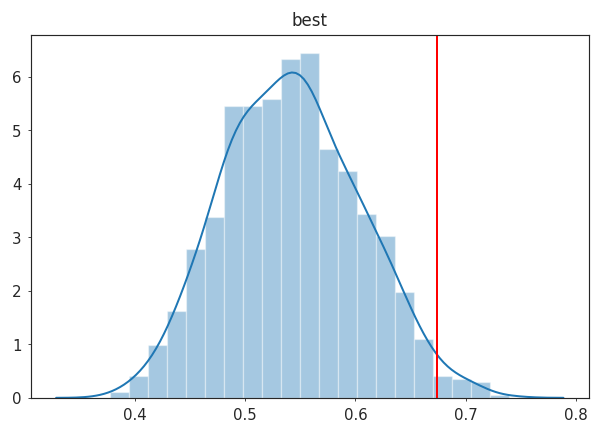

p=  0.0


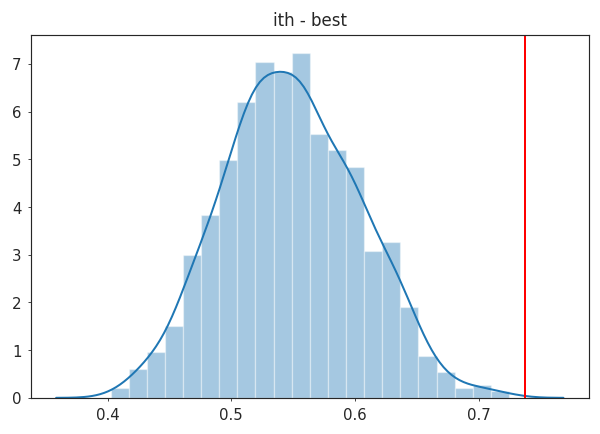

In [212]:
plt.title('best')
sns.distplot(corr_baseline_collapsed_p)
#sns.distplot(corr_collapsed_n)
plt.axvline(corr_best_collapsed_p_best, c='r')
print('p= ',p_best)
plt.show()


i = 1
plt.title('ith - best')
sns.distplot(corr_baseline_collapsed_p_n[i])
#sns.distplot(corr_collapsed_n)
plt.axvline(corr_collapsed_n[i], c='r')
print('p= ', p_n[i])

In [146]:
corr_collapsed_n.shape

(20,)

In [150]:
corr_model_collapsed

0.6736894837314747

In [159]:
corr_baseline_collapsed.shape

(20000,)

In [154]:
np.sum(corr_baseline_collapsed>corr_model_collapsed)/corr_baseline_collapsed.shape

array([0.01665])

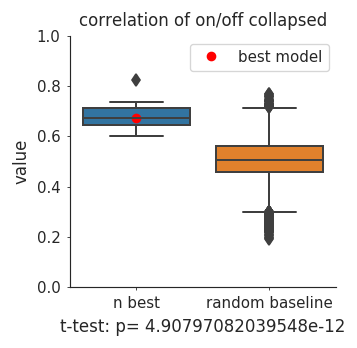

In [126]:
"""
correlation of collapsed
"""
save=False
filename = 'correlations_collapsed'


df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= corr_collapsed_n
df['setting'] = ['n best']*len(corr_collapsed_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline_collapsed
df2['setting'] = ['random baseline']*len(corr_baseline_collapsed)

df = df.append(df2)

plt.figure(1,figsize=(3,3))
plt.title('correlation of on/off collapsed')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            #ci='sd'
       )

plt.plot(0,
         corr_model_collapsed,
         'o',
        color='red',
        label='best model')
plt.legend()
plt.tight_layout()
plt.ylim(0,1)
sns.despine()
#plt.xticks([])

plt.xlabel('t-test: p= '+str(ttest_ind(corr_collapsed_n, corr_baseline_collapsed, equal_var=False)[1]))

if save:
    filepath =None
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [113]:
"""
on off ratio for one model
(for histogram)
"""

ratios_helm = get_onoff_ratios(w_helm_norm_sort)


w_best_norm = norm_full_w(w_best)
ratios_best = get_onoff_ratios(w_best_norm)

# Putting the -inf to value -18, and the two other outlier to -15

x = ratios_helm
helm_all = np.log2(np.sort(x))
print('small values:',helm_all[:5])
helm_all[0:2] = -14
helm_all[2:4] = -14

model_all = np.log2(ratios_best)

print(np.amin(helm_all))
print(np.amax(helm_all))

print(np.amin(model_all))
print(np.amax(model_all))

small values: [-38.49616105 -37.29961513 -16.70100697 -14.48427448  -5.49926474]
-14.0
4.080040587867099
-7.7128108269158995
10.115762525733432


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


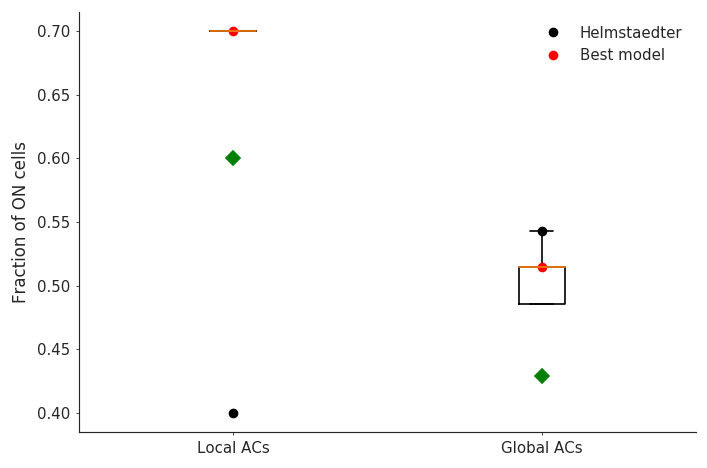

In [114]:
"""
fraction of on/off cells 
(for boxplot)
"""

# Helmstaedter 

ac_l_type_helm, ac_g_type_helm =  sorting(norm_full_w(w_helm_norm), return_types_only=True)
frac_on_l = np.sum(ac_l_type_helm == 1)/10
frac_on_g = np.sum(ac_g_type_helm == 1)/35


# Best model 
w_best_norm = norm_full_w(w_best)
ac_l_type_best, ac_g_type_best =  sorting(w_best_norm, return_types_only=True)
frac_m_on_l = np.sum(ac_l_type_best == 1)/10
frac_m_on_g = np.sum(ac_g_type_best == 1)/35


# n best models
fraction_on_local_n = []
fraction_on_global_n = []

for i in range(w_n.shape[0]):

    local_ac, global_ac = sorting(norm_full_w(w_n[i,:,:]), return_types_only=True)

    local_ON = np.sum(local_ac)/10

    global_ON = np.sum(global_ac)/35
    
    fraction_on_local_n.append(local_ON)
    fraction_on_global_n.append(global_ON)
    
fraction_on_local_n = np.array(fraction_on_local_n)
fraction_on_global_n = np.array(fraction_on_global_n)

# random baseline
fraction_on_local_baseline = []
fraction_on_global_baseline = []

for i in range(w_n.shape[0]):

    local_ac, global_ac = sorting(norm_full_w(w_random_all[i,:,:]), return_types_only=True)

    local_ON = np.sum(local_ac)/10

    global_ON = np.sum(global_ac)/35
    
    fraction_on_local_baseline.append(local_ON)
    fraction_on_global_baseline.append(global_ON)
    
fraction_on_local_baseline = np.array(fraction_on_local_baseline)
fraction_on_global_baseline = np.array(fraction_on_global_baseline)






################################################################
data_fraction = [fraction_on_local_n, fraction_on_global_n]

plt.boxplot(data_fraction, 0, 'gD')
plt.xticks([1, 2],['Local ACs', 'Global ACs'])
plt.plot(1, frac_on_l, 'o', color = 'black')
plt.plot(2, frac_on_g, 'o', color = 'black', label = 'Helmstaedter')

plt.plot(1, frac_m_on_l, 'o', color = 'red')
plt.plot(2, frac_m_on_g, 'o', color = 'red', label = 'Best model')
plt.legend(frameon = False)

plt.ylabel('Fraction of ON cells')
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.savefig('boxplot.png')
plt.show()


In [115]:
data_fraction

[array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
        0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.7]),
 array([0.51428571, 0.51428571, 0.51428571, 0.51428571, 0.48571429,
        0.51428571, 0.51428571, 0.48571429, 0.51428571, 0.42857143,
        0.48571429, 0.48571429, 0.54285714, 0.51428571, 0.51428571,
        0.51428571, 0.51428571, 0.54285714, 0.48571429, 0.48571429])]

# Final plot putting everything together

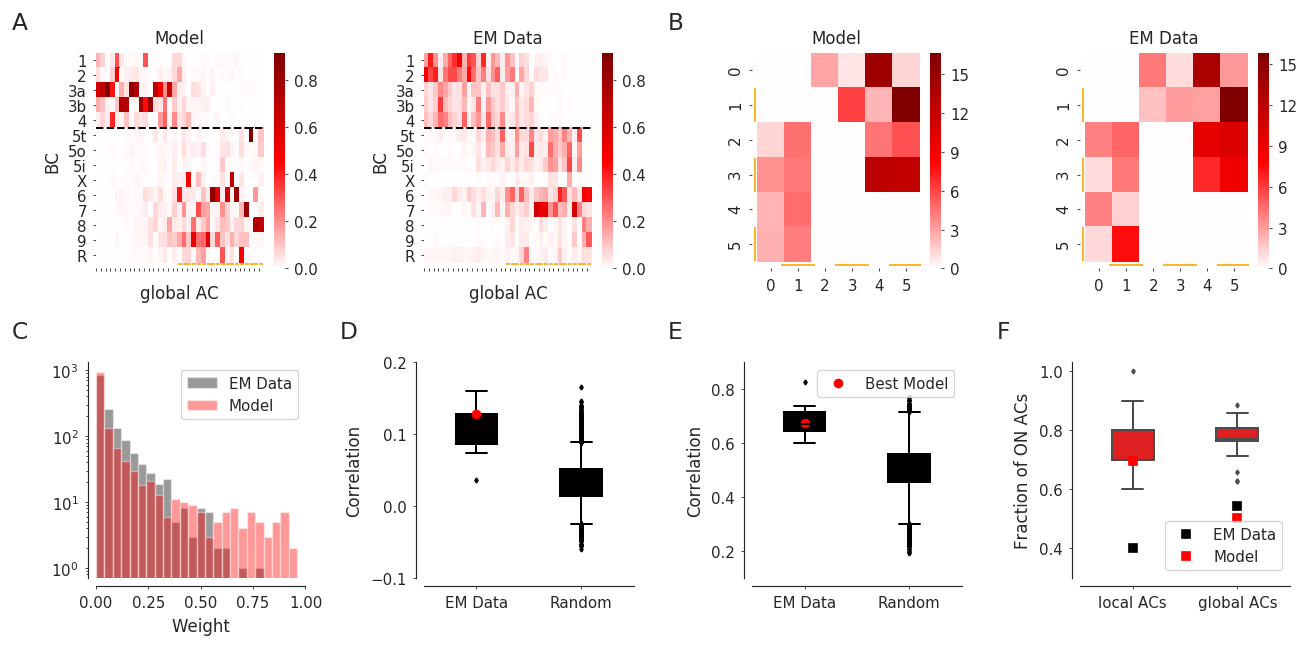

In [85]:
save= False
filename='fig5_v4'

layout = '''
 ABCD
 EFGH
 '''

bc_labels=['1',
         '2',
         '3a',
         '3b',
         '4',
         '5t',
         '5o',
         '5i',
         'X',
         '6',
         '7',
         '8',
         '9',
         'R']



# boxplot colors
color_all = 'black'
my_pal = {"Model": color_all, "Random": color_all, "EM Data":color_all, 'random baseline':color_all, 'n best':color_all}#"lightgrey"}
#sns.boxplot( x=df["species"], y=df["sepal_length"], palette=my_pal)




fig = plt.figure(figsize=(11, 5.5))
axes, spec = panels(layout, fig=fig)

#################################################################
"""
connectivities
"""

vmax = np.max(np.hstack([w_bc_acg_best, w_bc_acg_helm]))
markersize_onoffstripes=2
cmap = 'seismic'
#cmap= 'Greys'
ax =axes['A']
cmap = 'seismic'
center=0
plot_hline=5


#cmap = 'Reds'
ax.set_title('Model')
sns.heatmap(w_bc_acg_best.T,
                cmap=cmap,
                center=center,    
            yticklabels=bc_labels,
                #xticklabels=xticklabels
                square=False,
                vmax=vmax,
                vmin=0,
                ax=ax)

ax.set_xlabel(xlabels)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,35))
ax.axhline(plot_hline, ls='--', c='black')

# plot small stripes for AC type
ac_l_type = np.copy(ac_g_type_best)
ac_l_type[ac_g_type==0]= np.nan
ax.plot(np.arange(len(ac_g_type_best))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=markersize_onoffstripes,
        color='orange'
        )

ax.set_ylim(14.4,0)
sns.despine(left=True,bottom=True,ax=ax)
ax.set_xlabel('global AC')
ax.set_ylabel('BC')


ax =axes['B']
cmap = 'seismic'
center=0
ax.set_title('EM Data')
sns.heatmap(w_bc_acg_helm.T,
                cmap=cmap,
                center=center,
            vmin=0,    
            yticklabels=bc_labels,
                #xticklabels=xticklabels
                square=False,
                vmax=vmax,
                ax=ax)

ax.set_xlabel(xlabels)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,35))
ax.axhline(plot_hline, ls='--', c='black')

ac_l_type = np.copy(ac_g_type_helm)
ac_l_type[ac_l_type==0]= np.nan
# plot small stripes for AC type
ax.plot(np.arange(len(ac_g_type_helm))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=markersize_onoffstripes,
        color='orange'
        )

ax.set_ylim(14.4,0)
sns.despine(left=True,bottom=True,ax=ax)
ax.set_xlabel('global AC')
ax.set_ylabel('BC')
###############################################################

"""
on/off collapsed model WEIGHTS
"""
cbar=True
cmap='seismic'
vmin=0

ax = axes['C']

ax.set_title('Model')
sns.heatmap(w_model_collapsed.T,cmap=cmap,center=0,cbar=cbar,ax=ax,vmin=vmin)

# plot small stripes types
types = np.ones(6)
types[0]=np.nan
types[2]=np.nan
types[4]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*6.1,
         '_',
         markersize=20,
        color='orange'
        )

ax.plot(-types*0.1,
        np.arange(len(types))+0.5,
         '|',
         markersize=20,
        color='orange'
        )

ax.set_xlim(-0.2)
ax.set_ylim(6.2,0)



"""
on/off collapsed helm
"""
ax = axes['D']
ax.set_title('EM Data')
sns.heatmap(w_helm_collapsed.T,cmap=cmap,center=0,cbar=cbar,ax=ax,vmin=vmin)

# plot small stripes types
types = np.ones(6)
types[0]=np.nan
types[2]=np.nan
types[4]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*6.1,
         '_',
         markersize=20,
        color='orange'
        )

ax.plot(-types*0.1,
        np.arange(len(types))+0.5,
         '|',
         markersize=20,
        color='orange'
        )

ax.set_xlim(-0.2)
ax.set_ylim(6.2,0)

####################################################################
"""
weight distribution
"""

plot_laplace=False
bins = np.arange(0,1,0.04)

ax =axes['E']
const=1e-5
norm_hist=False
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(),
             bins=bins,
            kde=False,
            label='EM Data',
            norm_hist=norm_hist,
            color='black',
            ax=ax)

sns.distplot(#w_n_norm_sort[w_n_norm_sort>const].flatten(),
            w_best_norm_sort[w_best_norm_sort>const].flatten(),
             bins=bins,
             kde=False,
            label='Model',
            norm_hist=norm_hist,
            color='r',
            ax=ax)

if plot_laplace:
    # plot laplace distributions with fitted parameter
    t= np.arange(0,1,0.001)
    ax.plot(t, scp.stats.laplace.pdf(t,scale=b_helm), 
            color='black')
    ax.plot(t, scp.stats.laplace.pdf(t,scale=b_best), 
            color='red')

ax.set_yscale('log')
#plt.ylim(0.5)
ax.legend()
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xlim(0,1)
#ax.set_ylim(1e-2)
ax.set_xlabel('Weight')


#############################################
"""
correlation full
"""
ax =axes['F']
#ax.set_title('Correlation of model vs ...')

# set up dataframes
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= correlation_n
df['setting'] = ['EM Data']*len(correlation_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline
df2['setting'] = ['Random']*len(corr_baseline)

df = df.append(df2)


#ax.set_title('correlation(w_model, w_x) ')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            whis=True,
            ax=ax   ,
            color='black',
            #palette=my_pal,
            saturation=0.4,
            width=0.4,
            fliersize=2
           )

ax.plot(0,
         corr_model_best,
         'o',
        color='r',
        label='best model')
#plt.legend()
ax.set_ylim(-0.1,0.2)
ax.set_yticks([-0.1,0,0.1,0.2])

#ax.set_xlabel('t-test: p= '+str(ttest_ind(correlation_100, corr_baseline, equal_var=False)[1]))
sns.despine(ax=ax)
ax.set_xlabel('')
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

ax.set_ylabel('Correlation')

#############################################################
"""
collapsed correlation
"""
ax = axes['G']

# setting up datafram
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= corr_collapsed_n
df['setting'] = ['EM Data']*len(corr_collapsed_n)
df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline_collapsed
df2['setting'] = ['Random']*len(corr_baseline_collapsed)
df = df.append(df2)

#ax.set_title('Correlation of collapsed model vs ...')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            #ci='sd'
            ax=ax,
            #palette=my_pal,
            saturation=0,
            width=0.4,
            fliersize=2,
            color='black'
            
            
       )

ax.plot(0,
         corr_model_collapsed,
         'o',
        color='r',
        label='Best Model')
ax.legend()
sns.despine(ax=ax)
ax.set_ylim(0.1,0.9)
ax.set_xlabel('')
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

ax.set_ylabel('Correlation')

################################################
"""
fraction boxplot
"""
# plotting
ax = axes['H']

# set up dataframes
'''
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=fraction_on_global_n
df['setting'] = ['n best']*len(fraction_on_global_n)
df['type'] = ['global ACs']*len(fraction_on_global_n)


df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']= fraction_on_local_n
df2['setting'] = ['n best']*len(fraction_on_local_n)
df2['type'] = ['local ACs']*len(fraction_on_local_n)
df = df.append(df2)
'''

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=fraction_on_local_baseline
df['setting'] = ['random baseline']*len(fraction_on_local_baseline)
df['type'] = ['local ACs']*len(fraction_on_local_baseline)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=fraction_on_global_baseline
df2['setting'] = ['random baseline']*len(fraction_on_global_baseline)
df2['type'] = ['global ACs']*len(fraction_on_global_baseline)
df = df.append(df2)



sns.boxplot(x='type',
            y='value',
            orient='vertical',
            #hue='setting',
            data=df,
            #ci='sd'
            ax=ax,
            #palette=my_pal,
            #saturation=0,
            width=0.4,
            fliersize=2,
            color='red'
       )
# remove legend
#ax.legend_.remove()

# single points
ax.plot(1, frac_on_g, 's', color = 'black')
#ax.plot(0.2, frac_on_g, 'o', color = 'black')
#ax.plot([-0.3,0.3], [frac_on_g,frac_on_g], '--', color = 'black')

ax.plot(0, frac_on_l, 's', color = 'black', label = 'EM Data')
#ax.plot(1.2, frac_on_l, 'o', color = 'black')
#ax.plot([0.7,1.3], [frac_on_l,frac_on_l], '--', color = 'black')

# mean of models
ax.plot(1, np.mean(fraction_on_global_n), 's', color = 'red')
ax.plot(0, np.mean(fraction_on_local_n), 's', color = 'red', label = 'Model')

#best model
#ax.plot(1, frac_m_on_g, 'o', color = 'red')
#ax.plot(0, frac_m_on_l, 'o', color = 'red', label = 'Best model')

ax.set_ylim(0.3)
ax.legend()
ax.set_ylabel('Fraction of ON ACs')
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xlabel('')

#####################################################
"""
 general settings
"""
spec.set_width_ratios([1, 1, 1, 1])
label_panels_straight(axes, letters={'A':'A','B':'',
                                     'C':'B','D':'',
                                     'E':'C','F':'D','G':'E','H':'F'})
plt.tight_layout()
#sns.despine()
set_rcParams()

if save:
    filepath = 'None'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:441: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


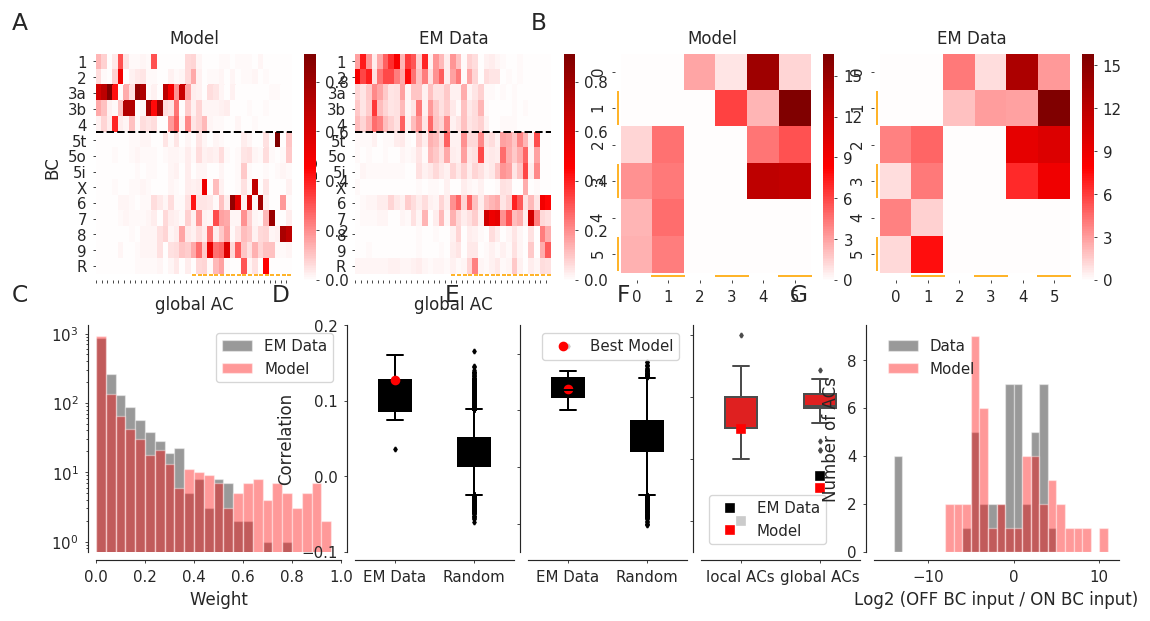

In [125]:
save= False
filename='fig5_v5'

layout = '''
 AAABBBCCCDDD
 EEEFFGGHHIII
 '''

bc_labels=['1',
         '2',
         '3a',
         '3b',
         '4',
         '5t',
         '5o',
         '5i',
         'X',
         '6',
         '7',
         '8',
         '9',
         'R']



# boxplot colors
color_all = 'black'
my_pal = {"Model": color_all, "Random": color_all, "EM Data":color_all, 'random baseline':color_all, 'n best':color_all}#"lightgrey"}
#sns.boxplot( x=df["species"], y=df["sepal_length"], palette=my_pal)




fig = plt.figure(figsize=(11, 5.5))
axes, spec = panels(layout, fig=fig)

#################################################################
"""
connectivities
"""

vmax = np.max(np.hstack([w_bc_acg_best, w_bc_acg_helm]))
markersize_onoffstripes=2
cmap = 'seismic'
#cmap= 'Greys'
ax =axes['A']
cmap = 'seismic'
center=0
plot_hline=5


#cmap = 'Reds'
ax.set_title('Model')
sns.heatmap(w_bc_acg_best.T,
                cmap=cmap,
                center=center,    
            yticklabels=bc_labels,
                #xticklabels=xticklabels
                square=False,
                vmax=vmax,
                vmin=0,
                ax=ax)

ax.set_xlabel(xlabels)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,35))
ax.axhline(plot_hline, ls='--', c='black')

# plot small stripes for AC type
ac_l_type = np.copy(ac_g_type_best)
ac_l_type[ac_g_type==0]= np.nan
ax.plot(np.arange(len(ac_g_type_best))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=markersize_onoffstripes,
        color='orange'
        )

ax.set_ylim(14.4,0)
sns.despine(left=True,bottom=True,ax=ax)
ax.set_xlabel('global AC')
ax.set_ylabel('BC')


ax =axes['B']
cmap = 'seismic'
center=0
ax.set_title('EM Data')
sns.heatmap(w_bc_acg_helm.T,
                cmap=cmap,
                center=center,
            vmin=0,    
            yticklabels=bc_labels,
                #xticklabels=xticklabels
                square=False,
                vmax=vmax,
                ax=ax)

ax.set_xlabel(xlabels)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,35))
ax.axhline(plot_hline, ls='--', c='black')

ac_l_type = np.copy(ac_g_type_helm)
ac_l_type[ac_l_type==0]= np.nan
# plot small stripes for AC type
ax.plot(np.arange(len(ac_g_type_helm))+0.5,
         ac_g_type*14.1,
         '_',
         markersize=markersize_onoffstripes,
        color='orange'
        )

ax.set_ylim(14.4,0)
sns.despine(left=True,bottom=True,ax=ax)
ax.set_xlabel('global AC')
ax.set_ylabel('BC')
###############################################################

"""
on/off collapsed model WEIGHTS
"""
cbar=True
cmap='seismic'
vmin=0

ax = axes['C']

ax.set_title('Model')
sns.heatmap(w_model_collapsed.T,cmap=cmap,center=0,cbar=cbar,ax=ax,vmin=vmin)

# plot small stripes types
types = np.ones(6)
types[0]=np.nan
types[2]=np.nan
types[4]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*6.1,
         '_',
         markersize=20,
        color='orange'
        )

ax.plot(-types*0.1,
        np.arange(len(types))+0.5,
         '|',
         markersize=20,
        color='orange'
        )

ax.set_xlim(-0.2)
ax.set_ylim(6.2,0)



"""
on/off collapsed helm
"""
ax = axes['D']
ax.set_title('EM Data')
sns.heatmap(w_helm_collapsed.T,cmap=cmap,center=0,cbar=cbar,ax=ax,vmin=vmin)

# plot small stripes types
types = np.ones(6)
types[0]=np.nan
types[2]=np.nan
types[4]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*6.1,
         '_',
         markersize=20,
        color='orange'
        )

ax.plot(-types*0.1,
        np.arange(len(types))+0.5,
         '|',
         markersize=20,
        color='orange'
        )

ax.set_xlim(-0.2)
ax.set_ylim(6.2,0)

####################################################################
"""
weight distribution
"""

plot_laplace=False
bins = np.arange(0,1,0.04)

ax =axes['E']
const=1e-5
norm_hist=False
sns.distplot( w_helm_norm_sort[w_helm_norm_sort>const].flatten(),
             bins=bins,
            kde=False,
            label='EM Data',
            norm_hist=norm_hist,
            color='black',
            ax=ax)

sns.distplot(#w_n_norm_sort[w_n_norm_sort>const].flatten(),
            w_best_norm_sort[w_best_norm_sort>const].flatten(),
             bins=bins,
             kde=False,
            label='Model',
            norm_hist=norm_hist,
            color='r',
            ax=ax)

if plot_laplace:
    # plot laplace distributions with fitted parameter
    t= np.arange(0,1,0.001)
    ax.plot(t, scp.stats.laplace.pdf(t,scale=b_helm), 
            color='black')
    ax.plot(t, scp.stats.laplace.pdf(t,scale=b_best), 
            color='red')

ax.set_yscale('log')
#plt.ylim(0.5)
ax.legend()
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xlim(0,1)
#ax.set_ylim(1e-2)
ax.set_xlabel('Weight')


#############################################
"""
correlation full
"""
ax =axes['F']
#ax.set_title('Correlation of model vs ...')

# set up dataframes
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= correlation_n
df['setting'] = ['EM Data']*len(correlation_n)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline
df2['setting'] = ['Random']*len(corr_baseline)

df = df.append(df2)


#ax.set_title('correlation(w_model, w_x) ')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            whis=True,
            ax=ax   ,
            color='black',
            #palette=my_pal,
            saturation=0.4,
            width=0.4,
            fliersize=2
           )

ax.plot(0,
         corr_model_best,
         'o',
        color='r',
        label='best model')
#plt.legend()
ax.set_ylim(-0.1,0.2)
ax.set_yticks([-0.1,0,0.1,0.2])

#ax.set_xlabel('t-test: p= '+str(ttest_ind(correlation_100, corr_baseline, equal_var=False)[1]))
sns.despine(ax=ax)
ax.set_xlabel('')
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

ax.set_ylabel('Correlation')

#############################################################
"""
collapsed correlation
"""
ax = axes['G']

# setting up datafram
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']= corr_collapsed_n
df['setting'] = ['EM Data']*len(corr_collapsed_n)
df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=corr_baseline_collapsed
df2['setting'] = ['Random']*len(corr_baseline_collapsed)
df = df.append(df2)

#ax.set_title('Correlation of collapsed model vs ...')
sns.boxplot(x='setting',
            y='value',
            orient='vertical',
            data=df,
            #ci='sd'
            ax=ax,
            #palette=my_pal,
            saturation=0,
            width=0.4,
            fliersize=2,
            color='black'
            
            
       )

ax.plot(0,
         corr_model_collapsed,
         'o',
        color='r',
        label='Best Model')
ax.legend()
sns.despine(ax=ax)
ax.set_ylim(0.1,0.9)
ax.set_xlabel('')
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

ax.set_ylabel('Correlation')

################################################
"""
fraction boxplot
"""
# plotting
ax = axes['H']

# set up dataframes
'''
df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=fraction_on_global_n
df['setting'] = ['n best']*len(fraction_on_global_n)
df['type'] = ['global ACs']*len(fraction_on_global_n)


df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']= fraction_on_local_n
df2['setting'] = ['n best']*len(fraction_on_local_n)
df2['type'] = ['local ACs']*len(fraction_on_local_n)
df = df.append(df2)
'''

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=fraction_on_local_baseline
df['setting'] = ['random baseline']*len(fraction_on_local_baseline)
df['type'] = ['local ACs']*len(fraction_on_local_baseline)

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=fraction_on_global_baseline
df2['setting'] = ['random baseline']*len(fraction_on_global_baseline)
df2['type'] = ['global ACs']*len(fraction_on_global_baseline)
df = df.append(df2)



sns.boxplot(x='type',
            y='value',
            orient='vertical',
            #hue='setting',
            data=df,
            #ci='sd'
            ax=ax,
            #palette=my_pal,
            #saturation=0,
            width=0.4,
            fliersize=2,
            color='red'
       )
# remove legend
#ax.legend_.remove()

# single points
ax.plot(1, frac_on_g, 's', color = 'black')
#ax.plot(0.2, frac_on_g, 'o', color = 'black')
#ax.plot([-0.3,0.3], [frac_on_g,frac_on_g], '--', color = 'black')

ax.plot(0, frac_on_l, 's', color = 'black', label = 'EM Data')
#ax.plot(1.2, frac_on_l, 'o', color = 'black')
#ax.plot([0.7,1.3], [frac_on_l,frac_on_l], '--', color = 'black')

# mean of models
ax.plot(1, np.mean(fraction_on_global_n), 's', color = 'red')
ax.plot(0, np.mean(fraction_on_local_n), 's', color = 'red', label = 'Model')

#best model
#ax.plot(1, frac_m_on_g, 'o', color = 'red')
#ax.plot(0, frac_m_on_l, 'o', color = 'red', label = 'Best model')

ax.set_ylim(0.3)
ax.legend()
ax.set_ylabel('Fraction of ON ACs')
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xlabel('')


#################################################

ax = axes['I']
bins = np.arange(-15,12,1)
kde=False
sns.distplot(helm_all, 
        #bins=np.arange(min(helm_all), max(helm_all) + binwidth, binwidth),
         color='black',
         bins=bins,
         label = 'Data', 
         ax=ax,
            kde=kde)

sns.distplot(model_all, 
         #bins=np.arange(min(model_all), max(model_all) + binwidth, binwidth),
         bins=bins,
         color = 'red',
         label = 'Model',
         ax=ax,
            kde=kde)


ax.set_xlabel('Log2 (OFF BC input / ON BC input)')
ax.set_ylabel('Number of ACs')
ax.legend(loc = 'upper left',frameon = False)
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

#####################################################
"""
 general settings
"""
spec.set_width_ratios([1, 1, 1, 1,1,1,1,1,1,1,1,1])
label_panels_straight(axes, letters={'A':'A','B':'',
                                     'C':'B','D':'',
                                     'E':'C','F':'D','G':'E','H':'F','I':'G'})
plt.tight_layout()
#sns.despine()
set_rcParams()

if save:'None'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

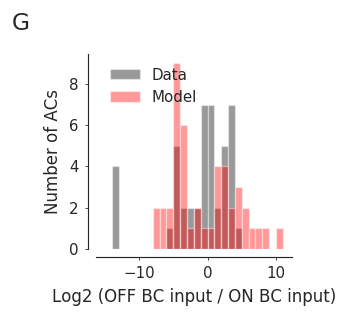

In [121]:
"""
Add this
"""
save = False
filename = 'log2_histo_input_weights'

layout = '''
 A
 '''

fig = plt.figure(figsize=(11/4, 2.75))
axes, spec = panels(layout, fig=fig)

ax = axes['A']
bins = np.arange(-15,12,1)
kde=False
sns.distplot(helm_all, 
        #bins=np.arange(min(helm_all), max(helm_all) + binwidth, binwidth),
         color='black',
         bins=bins,
         label = 'Data', 
         ax=ax,
            kde=kde)

sns.distplot(model_all, 
         #bins=np.arange(min(model_all), max(model_all) + binwidth, binwidth),
         bins=bins,
         color = 'red',
         label = 'Model',
         ax=ax,
            kde=kde)


ax.set_xlabel('Log2 (OFF BC input / ON BC input)')
ax.set_ylabel('Number of ACs')
ax.legend(loc = 'upper left',frameon = False)
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

"""
 general settings
"""
spec.set_width_ratios([1])
label_panels_straight(axes, letters={'A':'G'})
plt.tight_layout()
#sns.despine()
set_rcParams()

if save:
    filepath = None
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

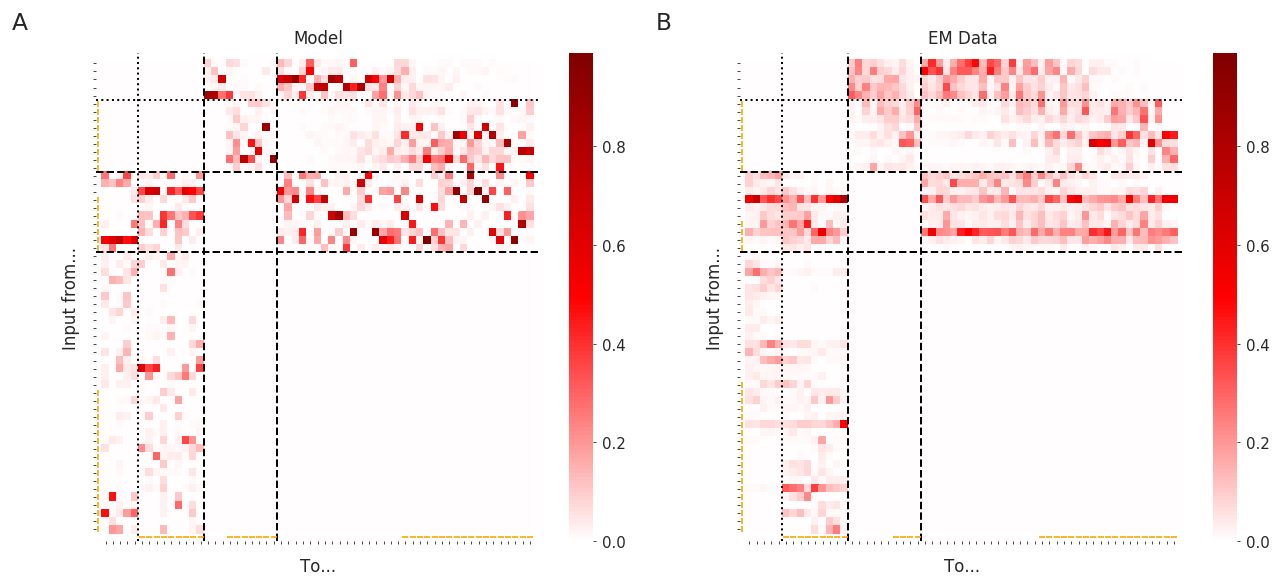

In [142]:
"""
nice plot of full matrix
"""
save= False
filename='fig_suppl_full_w'

layout = '''
 AB
 AB
 '''
fig = plt.figure(figsize=(11, 5))
axes, spec = panels(layout, fig=fig)

"""
general labels etc.
"""
bc_labels=bc_labels=['1', '2', '3a', '3b', '4', '5t', '5o', '5i', 'X', '6', '7', '8', '9', 'R']

#bc_labels=bc_labels=['1', '2', '3a/b', 
#                     #'3b', 
#                     '4', '5t/o/i', 
#                     #'5o', 
#                     #'5i', 
#                     'X', '6', '7', '8', '9', 'R']

#labels= bc_labels+list(np.arange(1,11))+['acg']*35
labels= []
#ticks = [0,1,2.5,4,6,8,9,10,11,12,13,]
ticks=np.arange(0,59)+0.5
linecolor='black'
vmax = max(np.max(w_helm_norm_sort), np.max(w_best_norm_sort))
ls_type = '--' # line style for celltypes
ls_on_off = ':' # line style for on/off seperation

"""
Model
"""
ax = axes['A']
ax.set_title('Model')
sns.heatmap((w_best_norm_sort).T,
           cmap='seismic',
           center=0,
           ax=ax,
           vmin=0,
           vmax=vmax)
# plot sepearating lines
ax.axhline(14,
           ls=ls_type,color=linecolor)
ax.axvline(14,
           ls=ls_type,color=linecolor)
ax.axhline(24,
           ls=ls_type,color=linecolor)
ax.axvline(24,
           ls=ls_type,color=linecolor)

ax.axhline(5,
           ls=ls_on_off,color=linecolor)
ax.axvline(5,
           ls=ls_on_off,color=linecolor)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
ax.set_ylabel('Input from...')
ax.set_xlabel('To...')


# plot small stripes for AC type
types = np.hstack([ac_l_type_best, ac_g_type_best])
bc_types = np.ones(14)
bc_types[:5]=np.nan
types = np.hstack([bc_types,types])
types[types==0]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*59.5,
         '_',
         markersize=4,
        color='orange'
        )

ax.plot(-types*0.5,
        np.arange(len(types))+0.5,
         '|',
         markersize=4,
        color='orange'
        )
ax.set_xlim(-0.8,60)
ax.set_ylim(60,-0.8)


"""
Helm
"""
ax = axes['B']
ax.set_title('EM Data')
sns.heatmap((w_helm_norm_sort).T,
           cmap='seismic',
           center=0,
           ax=ax,
           vmin=0,
           vmax=vmax)
# plot sepearating lines
ax.axhline(14,
           ls=ls_type,color=linecolor)
ax.axvline(14,
           ls=ls_type,color=linecolor)
ax.axhline(24,
           ls=ls_type,color=linecolor)
ax.axvline(24,
           ls=ls_type,color=linecolor)

ax.axhline(5,
           ls=ls_on_off,color=linecolor)
ax.axvline(5,
           ls=ls_on_off,color=linecolor)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
ax.set_ylabel('Input from...')
ax.set_xlabel('To...')


# plot small stripes for AC type
types = np.hstack([ac_l_type_helm, ac_g_type_helm])
bc_types = np.ones(14)
bc_types[:5]=np.nan
types = np.hstack([bc_types,types])
types[types==0]=np.nan
ax.plot(np.arange(len(types))+0.5,
         types*59.5,
         '_',
         markersize=4,
        color='orange'
        )

ax.plot(-types*0.5,
        np.arange(len(types))+0.5,
         '|',
         markersize=4,
        color='orange'
        )
ax.set_xlim(-0.8,60)
ax.set_ylim(60,-0.8)




"""
 general settings
"""
spec.set_width_ratios([1, 1])
label_panels_straight(axes, letters={'A':'A','B':'B'})
plt.tight_layout()
#sns.despine()

if save:
    filepath = None
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [82]:
(w_helm_norm_sort.T).sum(0)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2.])

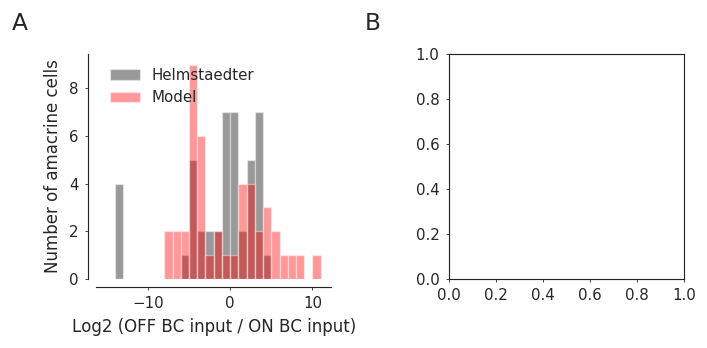

In [119]:
"""
reserve figures
"""

save= False
filename='log2_histogram'

layout = '''
 AB
 '''
fig = plt.figure(figsize=(6, 3))
axes, spec = panels(layout, fig=fig)

ax = axes['A']
bins = np.arange(-15,12,1)
kde=False
sns.distplot(helm_all, 
        #bins=np.arange(min(helm_all), max(helm_all) + binwidth, binwidth),
         color='black',
         bins=bins,
         label = 'Helmstaedter', 
         ax=ax,
            kde=kde)

sns.distplot(model_all, 
         #bins=np.arange(min(model_all), max(model_all) + binwidth, binwidth),
         bins=bins,
         color = 'red',
         label = 'Model',
         ax=ax,
            kde=kde)


ax.set_xlabel('Log2 (OFF BC input / ON BC input)')
ax.set_ylabel('Number of amacrine cells')
ax.legend(loc = 'upper left',frameon = False)
sns.despine(ax=ax)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

"""
on/off collapsed random
"""
ax = axes['B']

"""
 general settings
"""
spec.set_width_ratios([1,1])
label_panels_straight(axes, letters={'A':'A', 'B':'B'})
plt.tight_layout()
#sns.despine()

if save:
    filepath =None
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

In [112]:
ax.dendrogram_row.reordered_ind

#ax.dendrogram_col.reordered_ind

[2, 3, 9, 11, 5, 12, 10, 8, 13, 4, 6, 7, 0, 1]

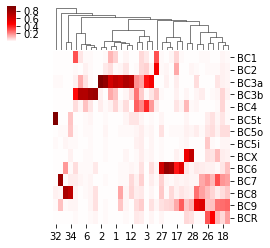

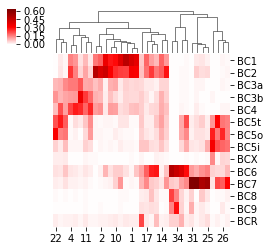

In [115]:
bc_labels=['BC1',
         'BC2',
         'BC3a',
         'BC3b',
         'BC4',
         'BC5t',
         'BC5o',
         'BC5i',
         'BCX',
         'BC6',
         'BC7',
         'BC8',
         'BC9',
         'BCR']

# set up dataframes

df = pd.DataFrame(columns=bc_labels, data=w_bc_acg_best)
ax = sns.clustermap(df.T, cmap='seismic', center=0,figsize=(4,4),row_cluster=False, cbar=True, col_cluster=True)


# set up dataframes
df = pd.DataFrame(columns=bc_labels, data=w_bc_acg_helm)
sns.clustermap(df.T, cmap='seismic', center=0,figsize=(4,4), row_cluster=False)
